In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
import warnings
import matplotlib.dates as dates
warnings.filterwarnings("ignore") # specify to ignore warning messages

C:\Users\josed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\josed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# reading data
df_origen = pd.read_csv(r".\data\nowcast_gdp_data.csv")
df_origen.set_index('date', inplace=True)
df = df_origen.copy()

# lagged variables
df['p_elec_lag'] = df['p_elec'].shift()
df['c_cement_lag'] = df['c_cement'].shift()
df['delta_empleo_lag'] = df['delta_empleo'].shift()
df['m_ind_inp_lag'] = df['m_ind_inp'].shift()
df['delta_bvl_lag'] = df['delta_bvl'].shift()

# Exogenous variables
X = pd.concat([df["p_elec"],           # Electricty production - Contemporaneous
               df["c_cement"],         # Cement Consumption  - Contemporaneous
               df["m_ind_inp"],        # Input Volume - Contemporaneous
               df["p_elec_lag"],       # Electricty production - Lagged
               df["c_cement_lag"],     # Cement Consumption  - Lagged
               df["delta_indpro"],     # US Production Index - Contemporaneous
               df["delta_empleo_lag"], # Lima Labor Income - Lagged
               df["m_ind_inp_lag"],    # Input Volume - Lagged
               df["cred_mn"],          # Local Currency Credit - Contemporaneous
               df["delta_bvl_lag"]],   # Sotck Market - Lagged
             axis=1)

# Nowcasting GDP Model
gdp_mod = sm.tsa.SARIMAX(df.loc['2004-02-29':'2022-12-31']["gdp"],
                         order = (1, 0, 0),
                         exog  = X.loc['2004-02-29':'2022-12-31'],
                         trend = 'c')
results_gdp = gdp_mod.fit()
gdp_nowcast = results_gdp.get_forecast(steps = 1,
                                       exog = X.loc['2023-01-31':])

df.loc['2023-01-31']['gdp'] = gdp_nowcast.predicted_mean
df

gdp    p_elec   c_cement  m_ind_inp    cred_mn  delta_empleo  \
date                                                                            
2004-01-31  3.674966  4.229032   6.868890 -16.532481  13.514563      0.598601   
2004-02-29  4.245959  7.350977   6.468289   9.215095   9.453369      2.283559   
2004-03-31  5.774257  5.436382   7.780494  -2.812554   8.226966      2.043150   
2004-04-30  4.247995  6.194900   2.201965   7.594470   5.003304      2.619078   
2004-05-31  3.950757  6.124446   2.770659  19.005229   4.772573      1.549395   
...              ...       ...        ...        ...        ...           ...   
2022-09-30  2.090679  4.888810  -2.362744   7.500270   4.152657      8.499622   
2022-10-31  2.321467  4.944038  -6.409437   5.490030   3.669293     10.622415   
2022-11-30  1.877236  6.513948  -2.100000   6.987623   3.204154     11.817667   
2022-12-31  0.862894  6.944949  -6.719785   6.974240   2.461737     11.430341   
2023-01-31 -0.561291  4.413785 -15.900735   6.622186   1.947663      9.990851   

            delta_bvl  delta_indpro  p_elec_lag  c_cement_lag  \
date                                                            
2004-01-31  79.913009      1.279270         NaN           NaN   
2004-02-29  76.578574      1.784901    4.229032      6.868890   
2004-03-31  94.734749      1.681143    7.350977      6.468289   
2004-04-30  59.889402      2.745899    5.436382      7.780494   
2004-05-31  61.851754      3.509352    6.194900      2.201965   
...               ...           ...         ...           ...   
2022-09-30   6.394772      4.731306    3.120912      1.280000   
2022-10-31   1.723618      3.189122    4.888810     -2.362744   
2022-11-30   9.985585      1.984680    4.944038     -6.409437   
2022-12-31   1.035443      1.146732    6.513948     -2.100000   
2023-01-31  -2.297308      0.789556    6.944949     -6.719785   

            delta_empleo_lag  m_ind_inp_lag  delta_bvl_lag  
date                                                        
2004-01-31               NaN            NaN            NaN  
2004-02-29          0.598601     -16.532481      79.913009  
2004-03-31          2.283559       9.215095      76.578574  
2004-04-30          2.043150      -2.812554      94.734749  
2004-05-31          2.619078       7.594470      59.889402  
...                      ...            ...            ...  
2022-09-30          6.183159      20.024885       6.794728  
2022-10-31          8.499622       7.500270       6.394772  
2022-11-30         10.622415       5.490030       1.723618  
2022-12-31         11.817667       6.987623       9.985585  
2023-01-31         11.430341       6.974240       1.035443  

[229 rows x 13 columns]

In [3]:
l = 18

In [4]:
# CI 95
ci_95 = gdp_nowcast.conf_int()

ci_95_l = df[-l:]["gdp"].copy()
ci_95_l[-1:] = ci_95['lower gdp'].values

ci_95_h = df[-l:]["gdp"].copy()
ci_95_h[-1:] = ci_95['upper gdp'].values

# CI 90
ci_90 = gdp_nowcast.conf_int(alpha = .10)

ci_90_l = df[-l:]["gdp"].copy()
ci_90_l[-1:] = ci_90['lower gdp'].values

ci_90_h = df[-l:]["gdp"].copy()
ci_90_h[-1:] = ci_90['upper gdp'].values

# CI 68
ci_68 = gdp_nowcast.conf_int(alpha = .32)

ci_68_l = df[-l:]["gdp"].copy()
ci_68_l[-1:] = ci_68['lower gdp'].values

ci_68_h = df[-l:]["gdp"].copy()
ci_68_h[-1:] = ci_68['upper gdp'].values

# CI 50
ci_50 = gdp_nowcast.conf_int(alpha = .50)

ci_50_l = df[-l:]["gdp"].copy()
ci_50_l[-1:] = ci_50['lower gdp'].values

ci_50_h = df[-l:]["gdp"].copy()
ci_50_h[-1:] = ci_50['upper gdp'].values

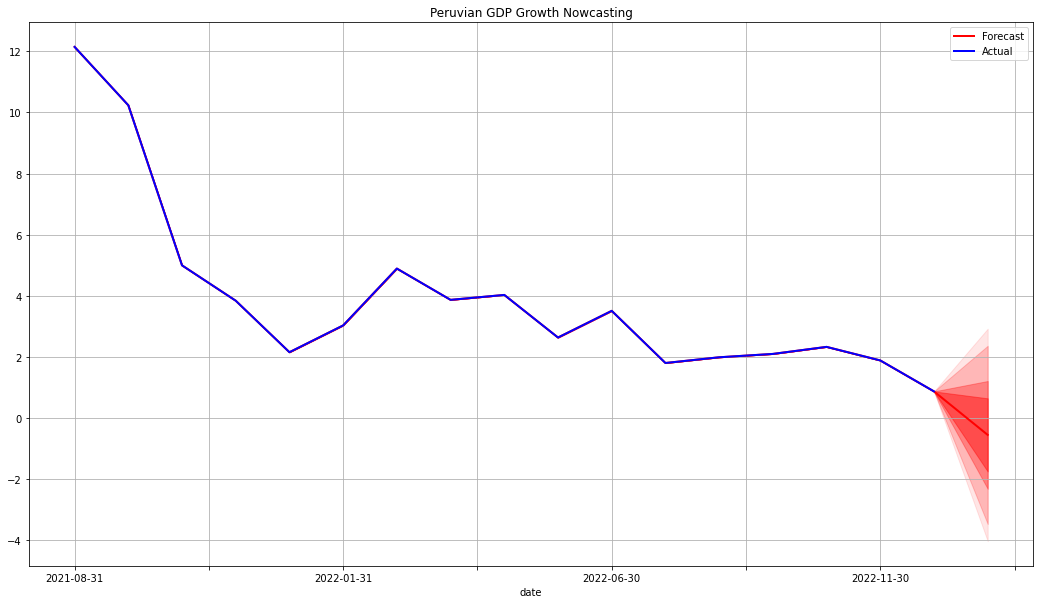

In [5]:
# Forecast Plot
ax = df[-l:]["gdp"].plot(figsize=(18, 10),color='r',linewidth=2.0)

# Actual Plot
df[-l:-1]["gdp"].plot(ax=ax, color='b', linewidth=2.0)

# CI95 Plot
ax.fill_between(ci_95_l.index, ci_95_l, ci_95_h, 
                color='r', alpha=.10)

# CI90 Plot
ax.fill_between(ci_95_l.index, ci_90_l, ci_90_h, 
                color='r', alpha=.20)

# CI68 Plot
ax.fill_between(ci_68_l.index, ci_68_l, ci_68_h, 
                color='r', alpha=.30)

# CI50 Plot
ax.fill_between(ci_50_l.index, ci_50_l, ci_50_h, 
                color='r', alpha=.40)

plt.legend(['Forecast','Actual'])
plt.title('Peruvian GDP Growth Nowcasting')
plt.grid()
plt.show()

In [6]:
fan_chart = pd.DataFrame({'q2.5': ci_95_l, 'q5': ci_90_l, 'q26': ci_68_l, 'q25': ci_50_l,
                         'q50': df[-l:]["gdp"].copy(),
                         'q75': ci_50_h, 'q84': ci_68_h, 'q90': ci_90_h, 'q95': ci_95_h})
fan_chart = fan_chart[-1:]
fan_chart

q2.5        q5       q26      q25       q50       q75  \
date                                                                    
2023-01-31 -4.040168 -3.480857 -2.326424 -1.75849 -0.561291  0.635908   

                 q84       q90       q95  
date                                      
2023-01-31  1.203841  2.358274  2.917586